### XGBOOST 
Algoritmo:  XGBOOST
Variables:  dia, noche, festivos
SE probaron todas las otras variables, incluyendo info de la fecha, y destruían valor en los indicadores

In [5]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import xgboost as xgb

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error


In [6]:
dfCOESBase = pd.read_excel('DemandaCOES.xlsx', skiprows=3)
dfCOESBase = dfCOESBase[['FECHA','EJECUTADO']]
dfCOESBase['FECHA'] = pd.to_datetime(dfCOESBase['FECHA'], format='%d/%m/%Y %H:%M')
# devolvemos todo 30 minutos para que asi no tengamos fechas del dia siguiente.
# antes del cambio  las 14:00 implicaban datos desde las 13:30 hasta las 14.  Luego del cambio significará desde las 14 hasta las 14:30
dfCOESBase['FECHA']= dfCOESBase['FECHA'] - pd.Timedelta(minutes=30)
dfCOESBase['Mes'] = dfCOESBase['FECHA'].dt.month
dfCOESBase['ano'] = dfCOESBase['FECHA'].dt.year
dfCOESBase['fechaYYYYMMDD'] = dfCOESBase['FECHA'].dt.strftime('%Y-%m-%d')
dfCOESBase['fechaYYYYMMDD'] = pd.to_datetime(dfCOESBase['fechaYYYYMMDD'])
dfCOESBase['real'] = dfCOESBase['EJECUTADO']

dfCOESNoche = dfCOESBase[(dfCOESBase['FECHA'].dt.hour >= 17) & (dfCOESBase['FECHA'].dt.hour < 23)].copy()
dfCOESNoche = dfCOESNoche.groupby('fechaYYYYMMDD')['EJECUTADO'].max().reset_index()
dfCOESNoche.rename(columns={'EJECUTADO': 'Noche'}, inplace=True)

# DIA: se toma solo el máximo de las madrugada hasta las 2pm (incluida)
dfCOESDia = dfCOESBase[(dfCOESBase['FECHA'].dt.hour >= 0) & (dfCOESBase['FECHA'].dt.hour < 14)].reset_index().copy()
dfCOESDia= dfCOESDia.groupby('fechaYYYYMMDD')['EJECUTADO'].max().reset_index()
dfCOESDia.rename(columns={'EJECUTADO': 'Dia'}, inplace=True)

dfCOESTarde = dfCOESBase[(dfCOESBase['FECHA'].dt.hour >= 14) & (dfCOESBase['FECHA'].dt.hour < 17)].reset_index().copy()
dfCOESTarde= dfCOESTarde.groupby('fechaYYYYMMDD')['EJECUTADO'].max().reset_index()
dfCOESTarde.rename(columns={'EJECUTADO': 'Tarde'}, inplace=True)

# dfCOESTotal tiene los datos de DIA y NOCHE 
dfCOESTotal = pd.merge(dfCOESDia, dfCOESTarde, on='fechaYYYYMMDD', how='left')
dfCOESTotal = pd.merge(dfCOESTotal, dfCOESNoche, on='fechaYYYYMMDD', how='left')


# OJO, QUITAMOS LOS DATOS ANTERIORES AL 2021 PUES SON MUY ATIPICOS
dfCOESTotal = dfCOESTotal[dfCOESTotal['fechaYYYYMMDD'] >= '2021-01-01']

dfCOESTotal['ano'] = dfCOESTotal['fechaYYYYMMDD'].dt.year
dfCOESTotal['mes'] = dfCOESTotal['fechaYYYYMMDD'].dt.month

dfCOESTotal = dfCOESTotal.reset_index(drop=True)

In [7]:
dfCOESTotal

,fechaYYYYMMDD,Dia,Tarde,Noche,ano,mes
0,2021-01-01,5733.86802,5403.67242,6068.57125,2021,1
1,2021-01-02,6286.83420,6137.84505,6541.48328,2021,1
2,2021-01-03,5854.06243,5882.37893,6526.14883,2021,1
3,2021-01-04,6630.26567,6695.74558,6744.20894,2021,1
4,2021-01-05,6765.53126,6729.17856,6834.35502,2021,1
...,...,...,...,...,...,...
1185,2024-03-31,6576.77453,6524.72391,7223.41316,2024,3
1186,2024-04-01,7663.10715,7716.05489,7548.07212,2024,4
1187,2024-04-02,7812.72365,7641.14840,7561.78331,2024,4
1188,2024-04-03,7658.46944,7676.32068,7514.04914,2024,4


## **31 MODELOS DISTINTOS**
La idea es entrenar con toda la data disponible desde el 2021 tal que se generen 31 modelos, uno por cada dia del mes

### **Simulamos para varios dias**

horizonte: 0


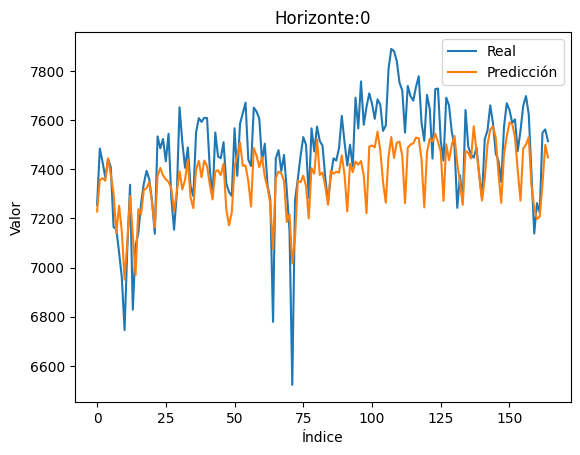

horizonte: 0


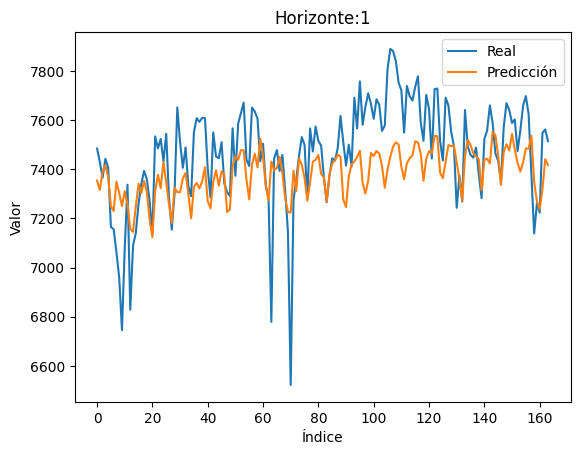

horizonte: 0


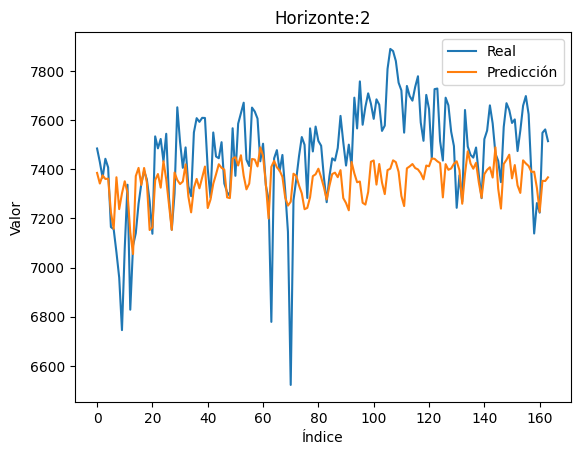

horizonte: 0


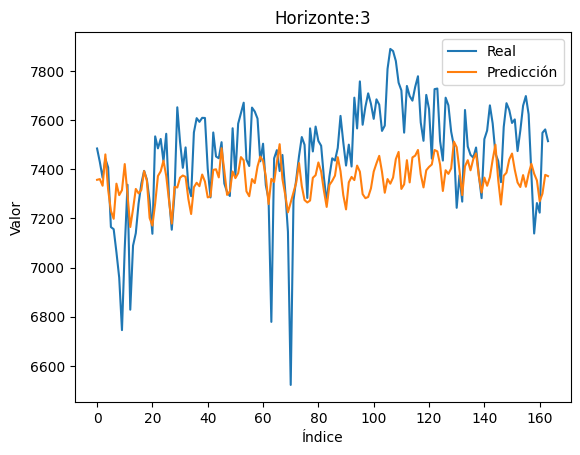

horizonte: 0


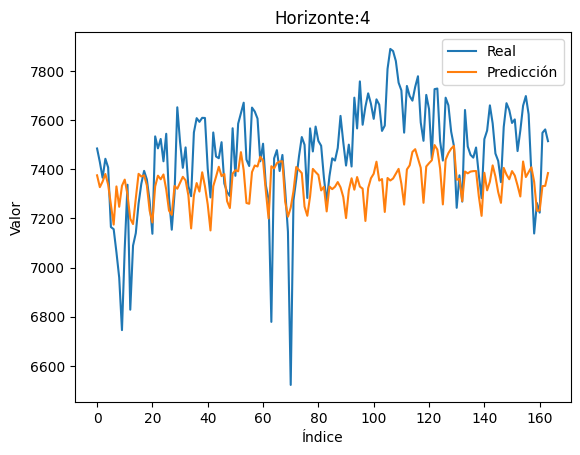

horizonte: 0


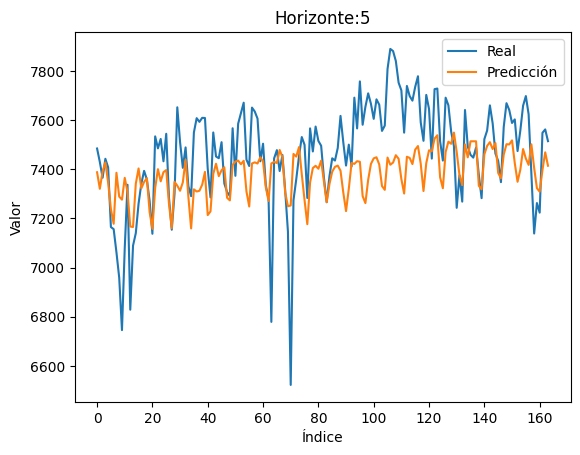

horizonte: 0


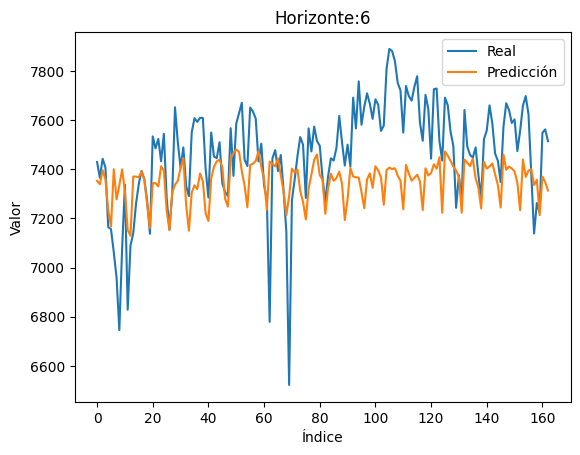

horizonte: 0


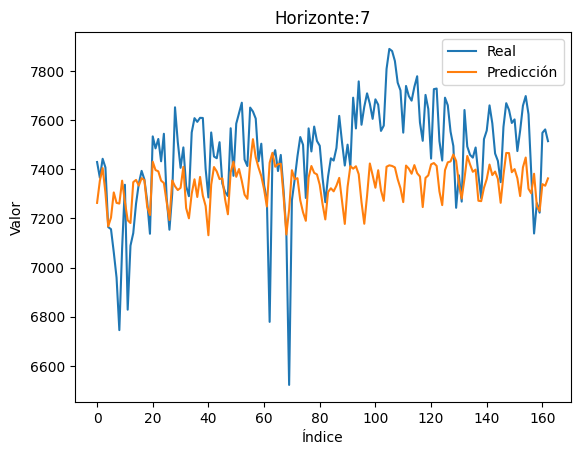

horizonte: 0


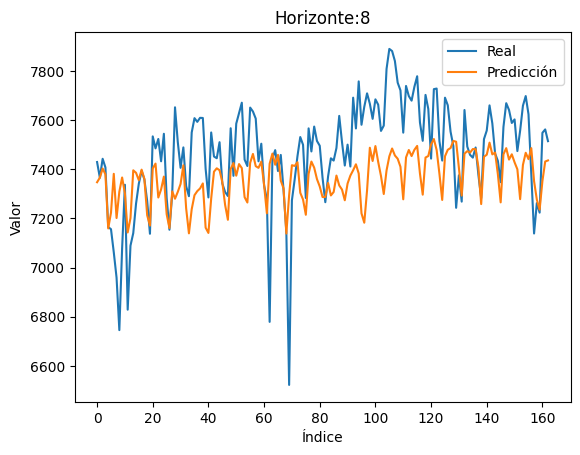

horizonte: 0


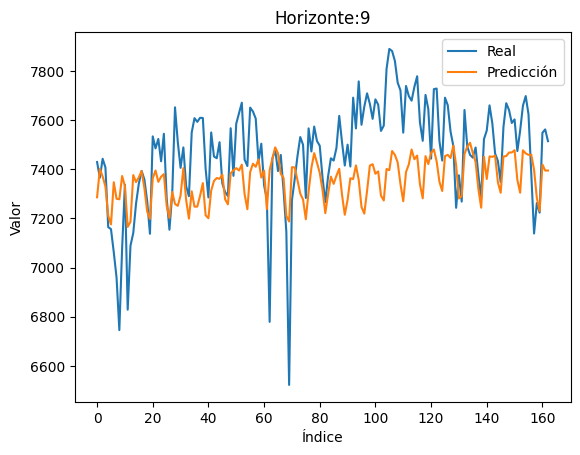

horizonte: 0


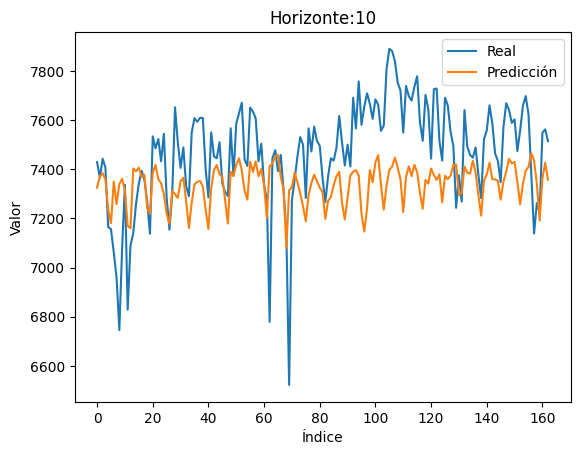

horizonte: 0


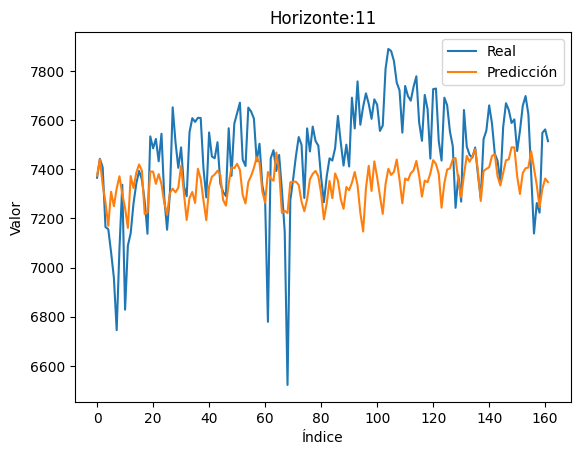

horizonte: 0


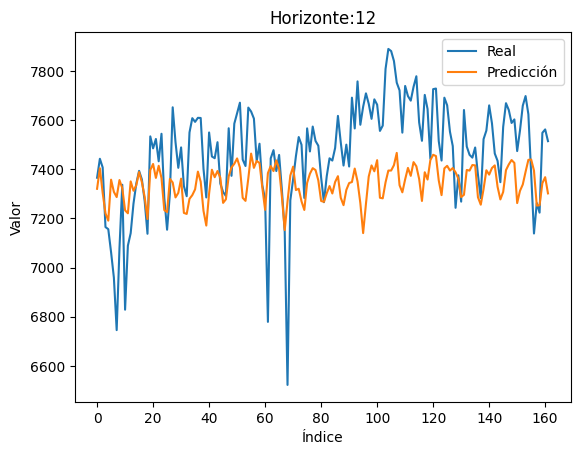

horizonte: 0


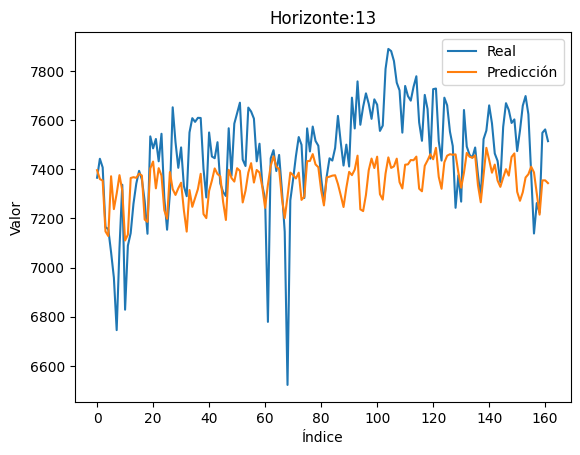

horizonte: 0


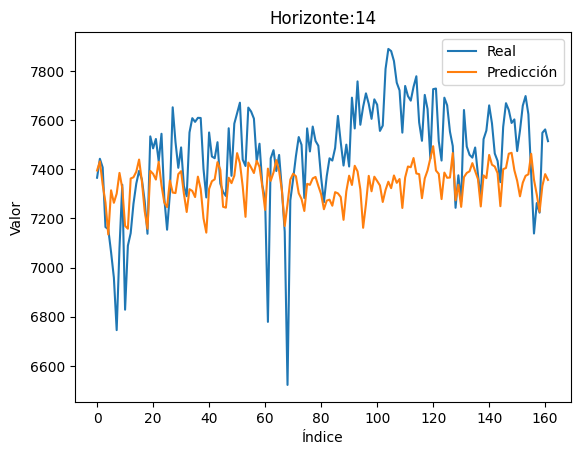

horizonte: 0


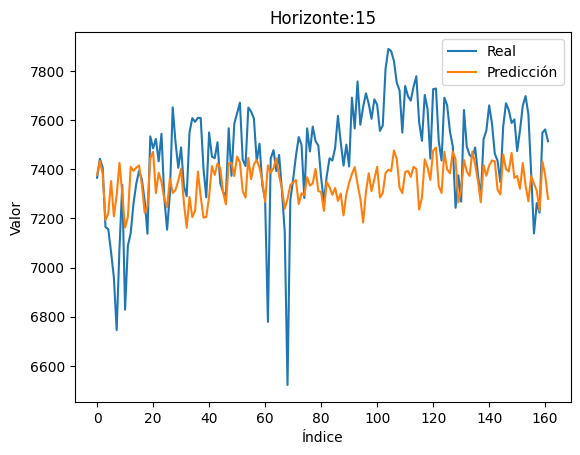

horizonte: 0


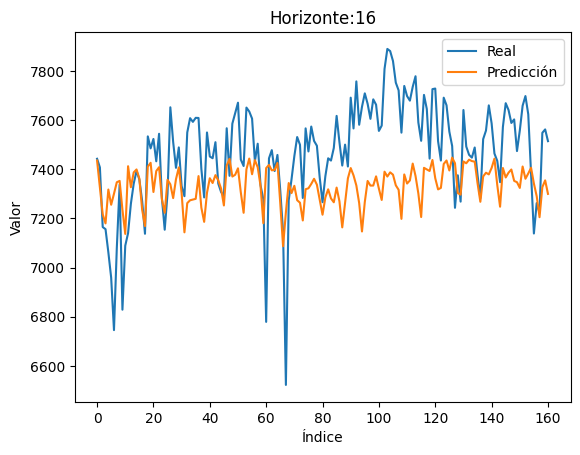

horizonte: 0


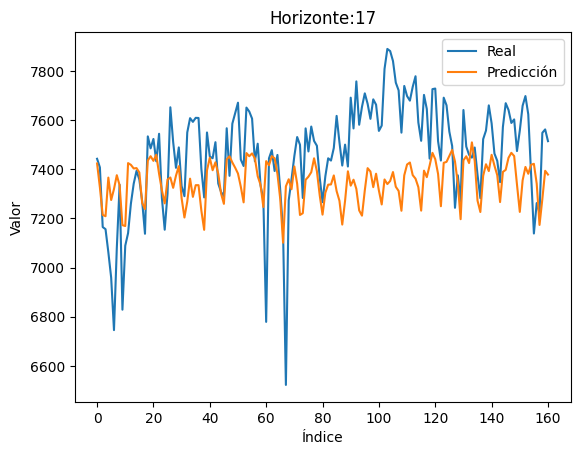

horizonte: 0


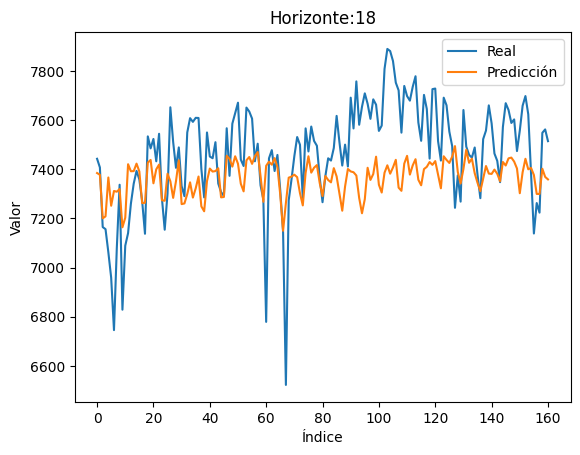

horizonte: 0


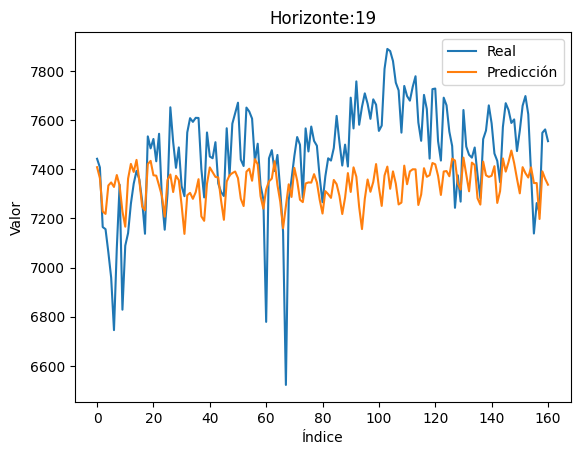

horizonte: 0


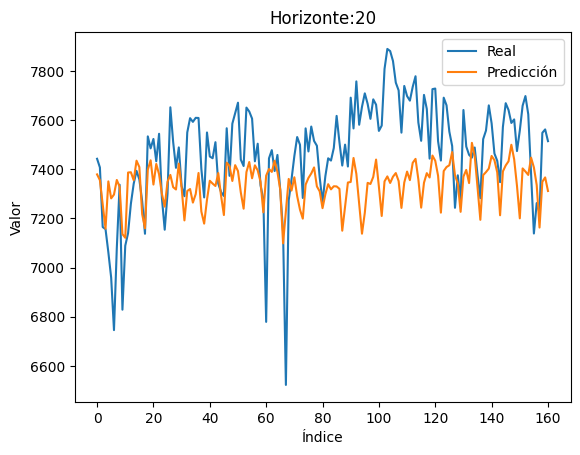

horizonte: 0


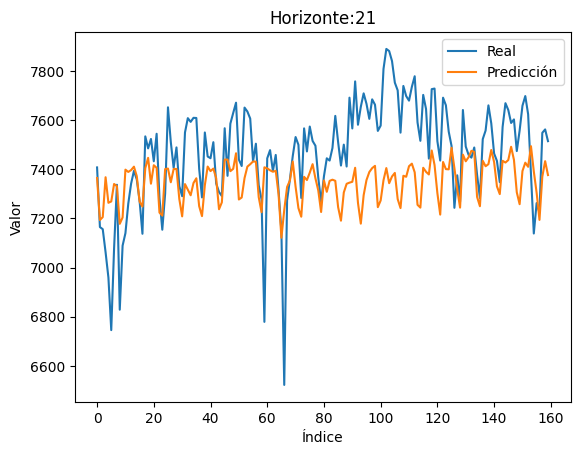

horizonte: 0


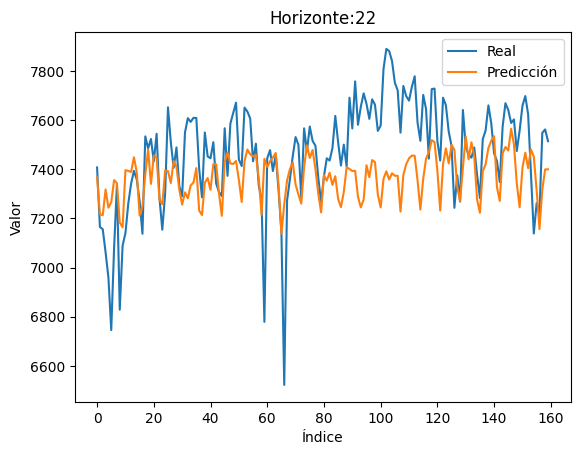

horizonte: 0


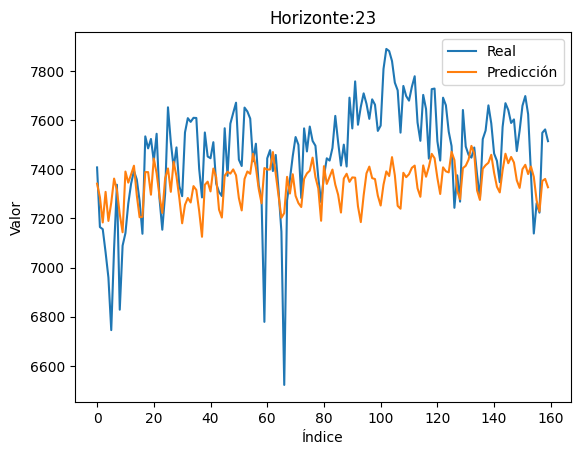

horizonte: 0


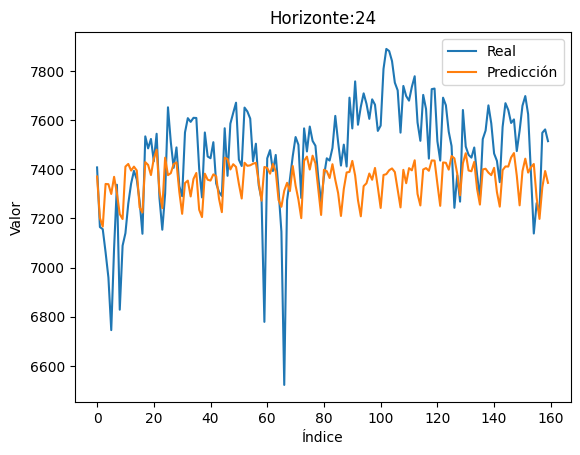

horizonte: 0


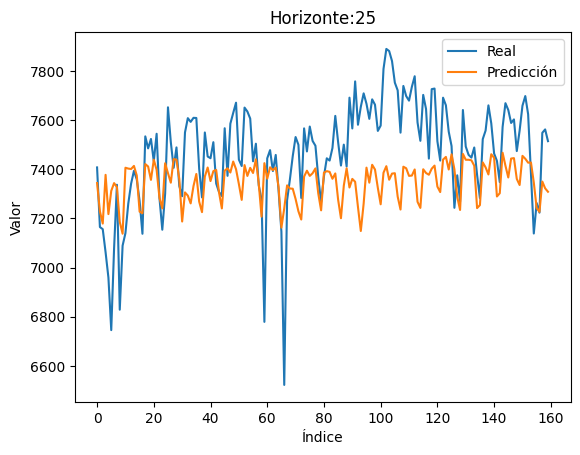

horizonte: 0


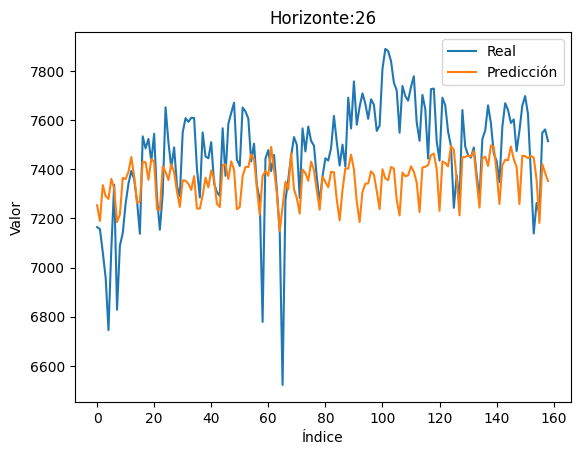

horizonte: 0


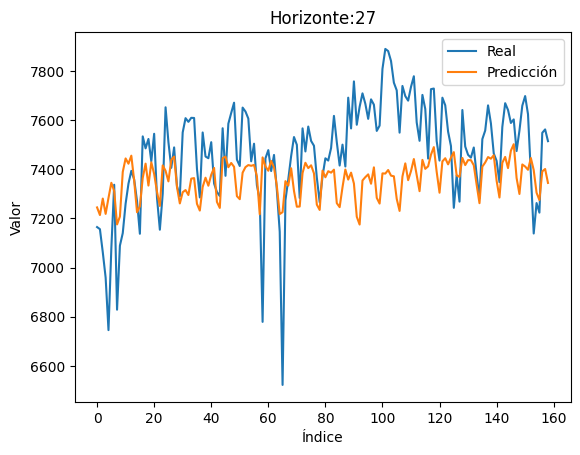

horizonte: 0


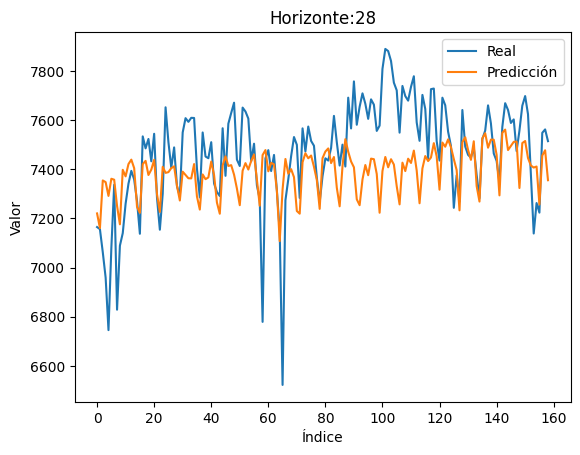

horizonte: 0


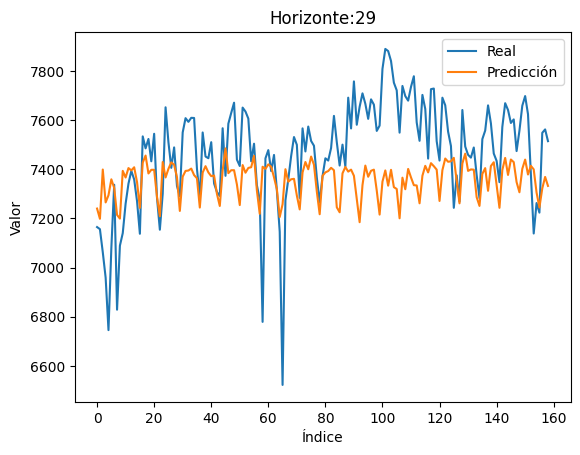

horizonte: 0


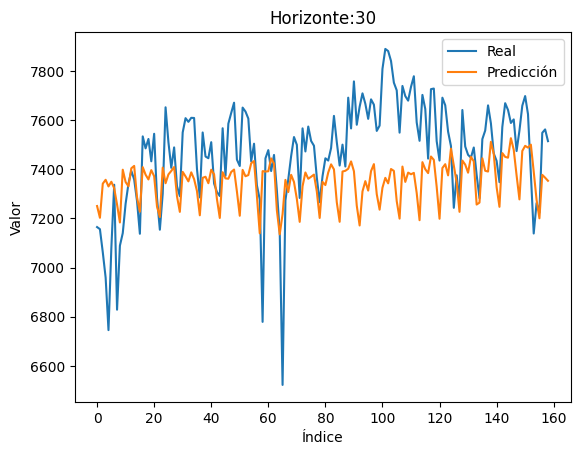

In [31]:
fechaAnalisisMinima = pd.to_datetime('2023-11-01 14:00')
fechaAnalisisMaxima = pd.to_datetime('2024-12-31 14:00')

# el vector listaResultadosFinales (fecha, esPico) indica los resultados para cada dia analizado
listaResultadosFinales = []

listaFechasTotales = []
listaHorizontesTotales = []
listaYPredsTotales = []

dfFestivos = pd.read_excel('Festivos peru.xlsx')
dfFestivos = dfFestivos[['diaYYYYMMDD']]
dfFestivos = dfFestivos.rename(columns ={'diaYYYYMMDD':'festivo'})
dfFestivos['festivo'] = pd.to_datetime(dfFestivos['festivo'], format='%Y%m%d')

# la idea es que dado un dia cualquiera, predecir dia + horizonte.

df = dfCOESTotal.copy()
df.reset_index(drop=True, inplace=True)   

df['diaDelMes'] = df['fechaYYYYMMDD'].dt.day
df['Mes'] = df['fechaYYYYMMDD'].dt.month
df['Trimestre'] = df['fechaYYYYMMDD'].dt.quarter
df['ano'] = df['fechaYYYYMMDD'].dt.year
df['diaDeLaSemana'] = df['fechaYYYYMMDD'].dt.dayofweek
df['diaDelAno'] = df['fechaYYYYMMDD'].dt.dayofyear
df['semanaDelAno'] = df['fechaYYYYMMDD'].dt.isocalendar().week

# obtenemos la marca de festivos
def verificaFestivo(fecha):
    if fecha in dfFestivos['festivo'].values:
        return 1
    return 0
df['festivo'] = df['fechaYYYYMMDD'].apply(verificaFestivo)

# convierte la data a numpy, con una historia "historia" valores para cada variable
# y se genera un "y" con un horizonte en dias a futuro.  Horizonte= 0 predice la noche
# del dia i.   horizonte=1 predice la siguiente noche y así sucesivamente.

# OJO:  data1 y data2 traen no solo training sino la fila a predecir, que es la última.

def df_a_numpy(data1, data2, data3, historia, horizonte):
    X0, X1, X2,  y = [], [], [], []

    iMax = len(data1) - historia - horizonte -1

    for i in range(iMax+1):   # el for en python llega hasta iMax RECORDAR!!!
        X0.append(data1[i:i+historia +1])     # DIA.  OJO, LAS SERIES traen una menos del final
        X1.append(data2[i:i+historia])   #  sin incluir la TARDE del dia de hoy
        X2.append(data3[i:i+historia])   #  sin incluir la NOCHE del dia de hoy
        y.append(data3[i+historia + horizonte])  # si horizo=0, se predice la Noche actual
    return np.array(X0), np.array(X1), np.array(X2), np.array(y)


# Definir los parámetros del modelo XGBoost
params = {
    'colsample_bytree':0.8,
    'learning_rate':0.1,
    'max_depth':5,
    'n_estimators': 400,
    'subsample':0.8
}

historia = 364   # un año de historia

listaModelos = []

for horizonte in range(0, 31):   # Horizonte dice a cuantos dias predecir

    print('horizonte:',0)

    # Inicializar el regresor XGBoost
    regressor = xgb.XGBRegressor(**params)

    # OJO, LA ULTIMA FILA - HORIZONTE ES PARA PREDICCION!!
    # EL RESTO SI ES PARA TRAININ

    X0 , X1,  X2, y = df_a_numpy(df['Dia'], df['Tarde'], df['Noche'], historia, horizonte) 
    X3 = (df.loc[historia + horizonte:, ['festivo']] == 'festivo').astype(int)

    # df['diaDelMes'] = df['fechaYYYYMMDD'].dt.day
    X4 = df.loc[historia + horizonte:, ['diaDelMes']]
    
    # df['Mes'] = df['fechaYYYYMMDD'].dt.month
    X5 = df.loc[historia + horizonte:, ['Mes']]

    # df['Trimestre'] = df['fechaYYYYMMDD'].dt.quarter
    X6 = df.loc[historia + horizonte:, ['Trimestre']]

    # df['ano'] = df['fechaYYYYMMDD'].dt.year
    # df['diaDeLaSemana'] = df['fechaYYYYMMDD'].dt.dayofweek
    X7 = df.loc[historia + horizonte:, ['diaDeLaSemana']]

    # df['diaDelAno'] = df['fechaYYYYMMDD'].dt.dayofyear
    X8 = df.loc[historia + horizonte:, ['diaDelAno']]

    # df['semanaDelAno'] = df['fechaYYYYMMDD'].dt.isocalendar().week
    X9 = df.loc[historia + horizonte:, ['semanaDelAno']]

    X = np.concatenate((X0, X1, X2, X3, X4, X5, X6, X7, X8, X9), axis=-1)

    totalFilas = len(X)
    totalEntrenamiento = (totalFilas*80)//100

    XTrain = X[:totalEntrenamiento, :]
    yTrain = y[:totalEntrenamiento]
    XTest = X[totalEntrenamiento:totalFilas-1, :]
    yTest = y[totalEntrenamiento:totalFilas-1]

    # Entrenamos
    regressor.fit(XTrain, yTrain)

    yPred = regressor.predict(XTest)
    # print('yPred:', len(yPred), yPred, yTest)

    plt.plot(yTest, label='Real')  # Graficar yTest en color azul
    plt.plot(yPred, label='Predicción')  # Graficar yPred en color naranja

    # Configurar etiquetas y leyenda
    plt.xlabel('Índice')  # Etiqueta del eje x
    plt.ylabel('Valor')  # Etiqueta del eje y
    plt.title('Horizonte:' + str(horizonte))  # Título del gráfico
    plt.legend()  # Mostrar leyenda

    # Mostrar el gráfico
    plt.show()



    # listaModelos.append(regressor)








    